# Validate Attention Attribution Results
This notebook contains a few functions used to validate the unexpected results encountered in the attention attribution experiments for the mBart50 model.

In [1]:
from typing import Optional
from datasets import load_from_disk
import inseq
from inseq.data.aggregator import AggregatorPipeline, SubwordAggregator, SequenceAttributionAggregator
import matplotlib.pyplot as plt
import numpy as np
import torch
from iwslt import preprocess


load datasets

In [2]:
ds = load_from_disk("../data/tatoeba_filtered")

#iwslt_ds = load_from_disk("../data/iwslt_labelled")
iwslt_en_only = preprocess.get_iwslt(categories=["telephony", "topical_chat", "test"], languages=["en"])

#### removed 0 old cache files ####


load interpolation function

In [3]:
def create_interpolation_plot(
    attr_list: list,
    scale_size: Optional[tuple] = None,
    plt_name: Optional[str] = "interpolation_plot",
    save: bool = False,
    scale_factor: Optional[float] = None,
) -> None:

    if scale_size is None:
        x = np.ceil(np.mean([attr.size(0) for attr in attr_list])).astype(int)
        y = np.ceil(np.mean([attr.size(1) for attr in attr_list])).astype(int)
        scale_size = (x, y)

    attr_list = [attr.unsqueeze(0).unsqueeze(0) for attr in attr_list]
    scaled_attr = [
        torch.nn.functional.interpolate(
            attr, size=scale_size, mode="bicubic", align_corners=True
        )
        .squeeze(0)
        .squeeze(0)
        for attr in attr_list
    ]

    scaled = torch.stack(scaled_attr).mean(dim=0).numpy()

    if scale_factor is not None:
        scaled = scaled * scale_factor

    arr = np.flip(scaled, axis=0)

    fig, ax = plt.subplots()

    pcm = ax.pcolormesh(arr, vmin=0, vmax=1, cmap="Reds")

    ax.set_xlabel("Generated Tokens")
    ax.set_ylabel("Attributed Tokens")

    fig.colorbar(pcm, ax=ax, shrink=0.8, location="right", label="Attention Weight")

    #fig.tight_layout()

    if save:
        fig.savefig(plt_name)


## mBart50
analyze the attention attribution on the mBart50 model

In [4]:
aggregator = AggregatorPipeline([SubwordAggregator])


In [5]:
mbart_model_de_ko = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "ko_KR"},
)


In [6]:
mbart_model_ko_de = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "ko_KR", "tgt_lang": "de_DE"},
)


In [7]:
mbart_attributions_de_ko_forced = mbart_model_de_ko.attribute(
    input_texts=ds[0]["source"],
    generated_texts=ds[0]["ko_nmt"],
    attribute_target=False,
    batch_size=32,
)
mbart_attributions_de_ko_forced = mbart_attributions_de_ko_forced.aggregate(
    aggregator=aggregator
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Attributing with attention...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.48it/s]


In [8]:
mbart_attributions_de_ko_forced.sequence_attributions[0].show()

,ko_KR,"▁캐롤,",▁여기,▁Vincent이,▁있습니다.,▁말하지,▁마세요.,▁그냥,▁들어보세요.,</s>
de_DE,0.195,0.266,0.31,0.316,0.218,0.243,0.195,0.259,0.2,0.196
"▁Carol,",0.07,0.205,0.025,0.005,0.018,0.005,0.022,0.003,0.01,0.046
▁hier,0.012,0.039,0.029,0.007,0.01,0.007,0.004,0.002,0.004,0.008
▁ist,0.008,0.019,0.023,0.008,0.004,0.002,0.002,0.0,0.003,0.004
▁Vincent.,0.024,0.094,0.138,0.129,0.039,0.024,0.016,0.005,0.019,0.052
▁Sag,0.016,0.017,0.015,0.01,0.049,0.084,0.008,0.004,0.003,0.008
▁nichts.,0.012,0.022,0.025,0.009,0.038,0.057,0.01,0.004,0.003,0.007
▁Hör,0.016,0.005,0.002,0.001,0.017,0.022,0.047,0.053,0.025,0.011
▁bloß,0.014,0.007,0.001,0.002,0.019,0.024,0.043,0.071,0.011,0.012
▁zu.,0.011,0.003,0.002,0.003,0.01,0.022,0.026,0.048,0.035,0.005


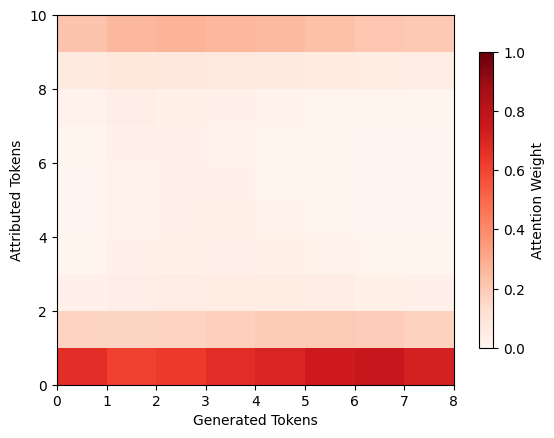

In [11]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_ko_forced.sequence_attributions
]
create_interpolation_plot(source_attr, plt_name="de_ko_forced")


In [10]:
mbart_attributions_de_ko_free = mbart_model_de_ko.attribute(
    input_texts=ds[0:160]["source"],
    generation_args={
        "forced_bos_token_id": mbart_model_de_ko.tokenizer.lang_code_to_id["ko_KR"]
    },
    attribute_target=False,
    batch_size=4,
)
mbart_attributions_de_ko_free = mbart_attributions_de_ko_free.aggregate(
    aggregator=aggregator
)


/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Attributing with attention...: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s]


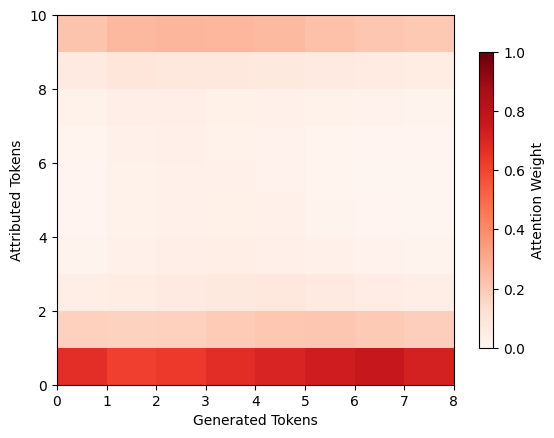

In [11]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_ko_free.sequence_attributions
]
create_interpolation_plot(source_attr, plt_name="de_ko_free")

In [11]:
mbart_attributions_de_ko_inp_grad = mbart_model_de_ko.attribute(
    input_texts=ds[0:1600]["source"],
    generated_texts=ds[0:1600]["ko_nmt"],
    attribute_target=False,
    batch_size=8,
    method="input_x_gradient",
)
mbart_attributions_de_ko_inp_grad = mbart_attributions_de_ko_inp_grad.aggregate(
    aggregator=AggregatorPipeline([SubwordAggregator, SequenceAttributionAggregator])
)

Attributing with input_x_gradient...: 100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


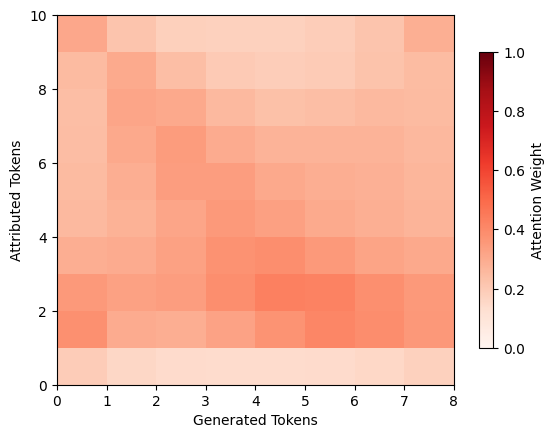

In [22]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_ko_inp_grad.sequence_attributions
]
create_interpolation_plot(source_attr, plt_name="de_ko_inp_grad", scale_factor=2)

In [9]:
mbart_attributions_ko_de_forced = mbart_model_ko_de.attribute(
    input_texts=ds[0]["target"],
    generated_texts=ds[0]["de_nmt"],
    attribute_target=False,
    batch_size=32,
)
mbart_attributions_ko_de_forced = mbart_attributions_ko_de_forced.aggregate(
    aggregator=aggregator
)


Attributing with attention...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.48it/s]


In [10]:
mbart_attributions_ko_de_forced.sequence_attributions[0].show()

,de_DE,"▁Carol,",▁don't,▁say,"▁""Naya","▁Vincent""!",</s>
ko_KR,0.201,0.229,0.241,0.214,0.215,0.227,0.213
"▁캐럴,",0.033,0.124,0.024,0.005,0.019,0.009,0.021
▁나야,0.007,0.026,0.058,0.039,0.072,0.004,0.004
▁빈센트,0.005,0.038,0.045,0.081,0.206,0.12,0.007
▁말하지,0.007,0.011,0.024,0.047,0.012,0.013,0.01
▁말고,0.017,0.068,0.063,0.022,0.011,0.02,0.017
▁들어,0.021,0.02,0.037,0.027,0.014,0.054,0.052
</s>,0.641,0.565,0.709,0.469,0.649,0.746,0.646


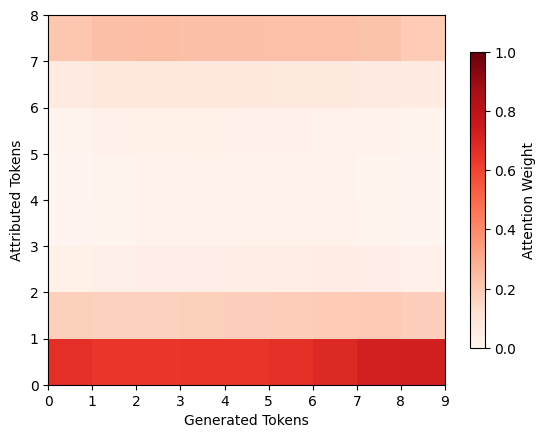

In [16]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_ko_de_forced.sequence_attributions
]
create_interpolation_plot(source_attr, plt_name="ko_de_forced")

In [15]:
mbart_model_de_en = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "en_XX"},
)


In [16]:
mbart_model_ko_en = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "ko_KR", "tgt_lang": "en_XX"},
)


In [17]:
mbart_attributions_de_en = mbart_model_de_en.attribute(
    input_texts=ds[0:160]["source"],
    generation_args={
        "forced_bos_token_id": mbart_model_de_en.tokenizer.lang_code_to_id["en_XX"]
    },
    attribute_target=False,
    batch_size=2,
)
mbart_attributions_de_en = mbart_attributions_de_en.aggregate(
    aggregator=aggregator
)


Attributing with attention...: 100%|██████████| 25/25 [00:03<00:00,  6.19it/s]


In [18]:
mbart_attributions_de_en.sequence_attributions[0].show()

,en_XX,"▁Carol,",▁here's,▁Vincent.,▁Don't,▁say,▁anything.,▁Just,▁listen.,</s>
de_DE,0.195,0.258,0.244,0.314,0.227,0.193,0.192,0.211,0.175,0.179
"▁Carol,",0.07,0.098,0.063,0.038,0.021,0.008,0.024,0.017,0.005,0.053
▁hier,0.012,0.067,0.04,0.021,0.027,0.009,0.008,0.005,0.003,0.013
▁ist,0.008,0.026,0.024,0.016,0.008,0.005,0.004,0.002,0.002,0.006
▁Vincent.,0.024,0.086,0.141,0.138,0.051,0.021,0.032,0.014,0.012,0.053
▁Sag,0.016,0.017,0.02,0.022,0.059,0.042,0.023,0.01,0.009,0.013
▁nichts.,0.012,0.026,0.027,0.02,0.04,0.025,0.028,0.007,0.005,0.009
▁Hör,0.016,0.007,0.006,0.008,0.014,0.015,0.033,0.068,0.045,0.02
▁bloß,0.014,0.01,0.005,0.009,0.015,0.009,0.03,0.049,0.03,0.017
▁zu.,0.011,0.008,0.015,0.009,0.013,0.009,0.016,0.024,0.029,0.007


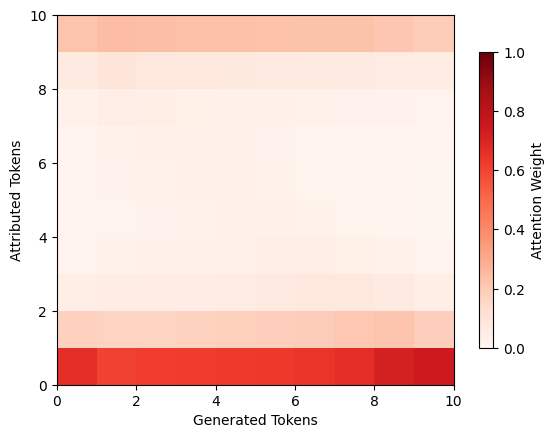

In [19]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_en.sequence_attributions
]
create_interpolation_plot(source_attr, plt_name="de_en")

In [20]:
mbart_attributions_ko_en = mbart_model_ko_en.attribute(
    input_texts=ds[0:160]["source"],
    generation_args={
        "forced_bos_token_id": mbart_model_ko_en.tokenizer.lang_code_to_id["en_XX"]
    },
    attribute_target=False,
    batch_size=8,
)
mbart_attributions_ko_en = mbart_attributions_ko_en.aggregate(
    aggregator=aggregator
)


Attributing with attention...: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


In [21]:
mbart_attributions_ko_en.sequence_attributions[0].show()

,en_XX,"▁Carol,",▁here,▁is,▁Vincent.,▁Say,▁nothing.,▁Just,▁listen,▁to,▁me.,</s>
ko_KR,0.194,0.26,0.23,0.199,0.31,0.242,0.193,0.208,0.157,0.154,0.19,0.166
"▁Carol,",0.072,0.085,0.048,0.011,0.019,0.034,0.024,0.008,0.004,0.007,0.014,0.037
▁hier,0.011,0.068,0.045,0.015,0.017,0.017,0.006,0.002,0.002,0.002,0.005,0.01
▁ist,0.007,0.026,0.024,0.039,0.023,0.007,0.006,0.001,0.004,0.005,0.005,0.006
▁Vincent.,0.019,0.055,0.08,0.061,0.089,0.039,0.019,0.006,0.012,0.024,0.041,0.032
▁Sag,0.022,0.046,0.02,0.007,0.052,0.105,0.032,0.015,0.012,0.005,0.008,0.028
▁nichts.,0.009,0.021,0.014,0.008,0.023,0.049,0.021,0.006,0.006,0.008,0.007,0.008
▁Hör,0.02,0.013,0.007,0.003,0.012,0.02,0.036,0.082,0.06,0.018,0.021,0.021
▁bloß,0.013,0.012,0.005,0.003,0.01,0.022,0.025,0.054,0.029,0.029,0.019,0.015
▁zu.,0.012,0.016,0.019,0.015,0.029,0.028,0.05,0.091,0.117,0.101,0.103,0.034


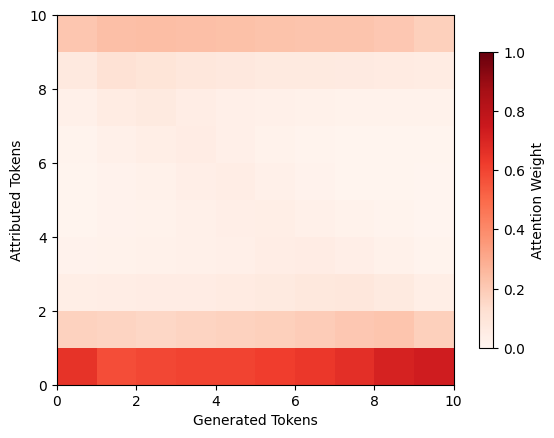

In [22]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_ko_en.sequence_attributions
]
create_interpolation_plot(source_attr, plt_name="ko_en")

## NLLB
analyze the attention attribution on the NLLB model

In [ ]:
nllb_model = inseq.load_model(
    "facebook/nllb-200-distilled-600M",
    "attention",
    tokenizer_kwargs={"src_lang": "deu_Latn", "tgt_lang": "kor_Hang"},
)


In [ ]:
out = nllb_model.attribute(
    input_texts=ds[0:16]["source"],
    generation_args={
        "forced_bos_token_id": nllb_model.tokenizer.lang_code_to_id["kor_Hang"]
    },
    attribute_target=False,
    batch_size=8,
)
out.show()


## OPUS-MT
analyze the attention attribution on the OPUS-MT model

In [ ]:
# "Helsinki-NLP/opus-mt-en-de"
opus_model = inseq.load_model("Helsinki-NLP/opus-mt-de-en", "attention")


In [ ]:
out = opus_model.attribute(
    input_texts=ds[0:16]["source"], attribute_target=False, batch_size=8
)
out.show()


In [2]:
import json

In [3]:
data = {}
with open("../plots/interpolations.json", "r") as f:
    data = json.load(f)

In [4]:
from get_interpol_plot_helper import create_interpolation_plot_multi

In [7]:
for plot in data:
    print(plot["title"])

MBart50 DE -> KO
MBart50 KO -> DE
MBart50 DE -> EN
MBart50 KO -> EN
MBart50 EN -> DE
MBart50 EN -> KO
NLLB DE -> KO
NLLB KO -> DE
NLLB DE -> EN
OPUS DE -> EN
OPUS EN -> DE
OPUS EN -> KO


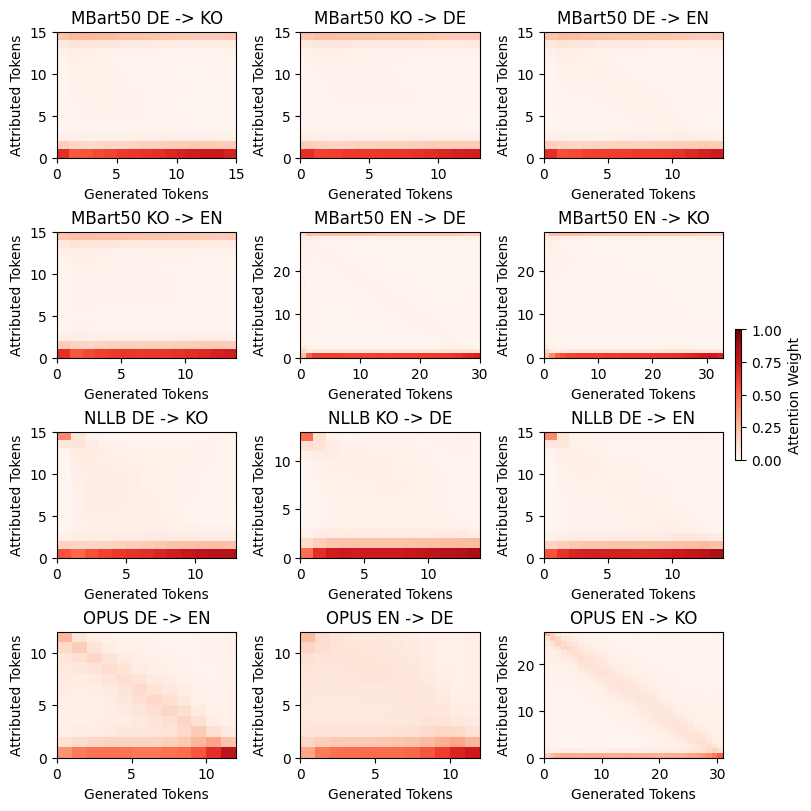

In [5]:
create_interpolation_plot_multi(
        data, save=True, plt_name="../plots/interpolations.png"
    )